
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [176]:
# Importação das bibliotecas
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [131]:
# Carregando 50-dimensional GloVe embeddings
glove_file = '../embeddings/glove.6B.50d.txt'
glove_embeddings = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.array(values[1:], dtype='float32')
        
        # Tratando a substituição da vírgula por ponto no vetor de embedding
        if ',' in values[1]:
            embedding = [float(val.replace(',', '.')) for val in values[1:]]
        
        glove_embeddings[word] = embedding

In [133]:
embedding_dim = len(next(iter(glove_embeddings.values())))

print('Achados %s vetores de palavras' % len(glove_embeddings))
print(f'Vetores de {embedding_dim} dimensões')

Achados 400000 vetores de palavras
Vetores de 50 dimensões


In [186]:
# Carregando dataset pre-processado
df = pd.read_csv('../datasets/buscape_preprocessed_balanced_cleared.csv')

In [188]:
print(pd.Series(df['rating']).value_counts())

rating
0    6810
1    6810
Name: count, dtype: int64


In [197]:
documents = df['review_text']
labels = np.array(df['rating'])

In [198]:
# Tokenização e embedding dos documentos
max_sequence_length = 20  # Número máximo de palavras por documento
embedded_documents = []
for doc in documents:
    words = doc.lower().split()
    embedded_doc = [glove_embeddings.get(word, np.zeros(embedding_dim)) for word in words]
    if len(embedded_doc) < max_sequence_length:
        embedded_doc.extend([np.zeros(embedding_dim)] * (max_sequence_length - len(embedded_doc)))
    else:
        embedded_doc = embedded_doc[:max_sequence_length]
    embedded_documents.append(embedded_doc)

embedded_documents = np.array(embedded_documents)

In [199]:
# Arquitetura de rede neural MLP
model = Sequential()
model.add(Dense(24, activation="relu", input_shape=(max_sequence_length, embedding_dim)))
model.add(Flatten())
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 20, 24)            1224      
                                                                 
 flatten_10 (Flatten)        (None, 480)               0         
                                                                 
 dropout_6 (Dropout)         (None, 480)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 481       
                                                                 
Total params: 1,705
Trainable params: 1,705
Non-trainable params: 0
_________________________________________________________________


In [201]:
LEARNING_RATE = 5e-4
LOSS = 'binary_crossentropy'
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
METRICS = ['acc']
BATCH_SIZE = 32
EPOCHS = 10
CALLBACKS = [EarlyStopping('val_loss', patience=5)]
VERBOSE=1

In [202]:
# Compilando o modelo
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER, 
    metrics=METRICS
)

In [203]:
# k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [204]:
fold_accuracies = []
fold_f1_scores = []
for fold, (train_idx, test_idx) in enumerate(skf.split(embedded_documents, labels), start=1):
    X_train, X_test = embedded_documents[train_idx], embedded_documents[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    model_history = model.fit(
        X_train, 
        y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        verbose=VERBOSE,
        validation_data=(X_test, y_test),
        callbacks=CALLBACKS
    )
    
    _, fold_accuracy = model.evaluate(X_test, y_test)
    fold_accuracies.append(fold_accuracy)
    
    # Predições das labels
    y_pred = (model.predict(X_test) > 0.5).astype(int) 
    
    # Calculando F1 score
    fold_f1 = f1_score(y_test, y_pred)  
    fold_f1_scores.append(fold_f1)
    
    print(f"Fold {fold}: Accuracy = {fold_accuracy:.2f}, F1 Score = {fold_f1:.2f}")

# Calculando acuracia
avg_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy: {avg_accuracy:.2f}")

# Calculando f1 score
avg_f1_score = np.mean(fold_f1_scores)
print(f"Average F1 Score: {avg_f1_score:.2f}")

Epoch 1/10
384/384 [==============================] - 1s 2ms/step - loss: 0.6799 - acc: 0.5737 - val_loss: 0.6494 - val_acc: 0.6182
Epoch 2/10
384/384 [==============================] - 1s 2ms/step - loss: 0.6192 - acc: 0.6575 - val_loss: 0.6197 - val_acc: 0.6512
Epoch 3/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5847 - acc: 0.6947 - val_loss: 0.5991 - val_acc: 0.6681
Epoch 4/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5649 - acc: 0.7053 - val_loss: 0.5903 - val_acc: 0.6777
Epoch 5/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5525 - acc: 0.7204 - val_loss: 0.5785 - val_acc: 0.6858
Epoch 6/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5433 - acc: 0.7224 - val_loss: 0.5714 - val_acc: 0.6931
Epoch 7/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5359 - acc: 0.7313 - val_loss: 0.5663 - val_acc: 0.6990
Epoch 8/10
384/384 [==============================] - 1s 2ms/step - loss: 0.

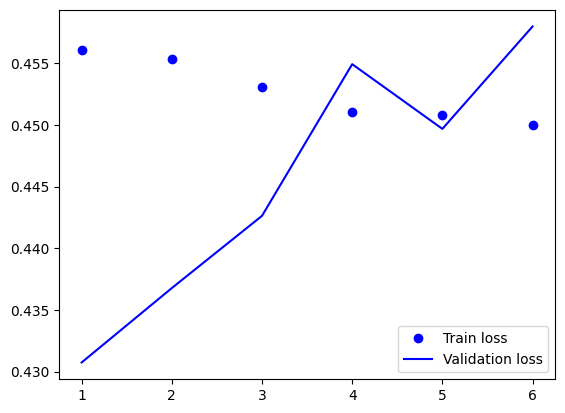

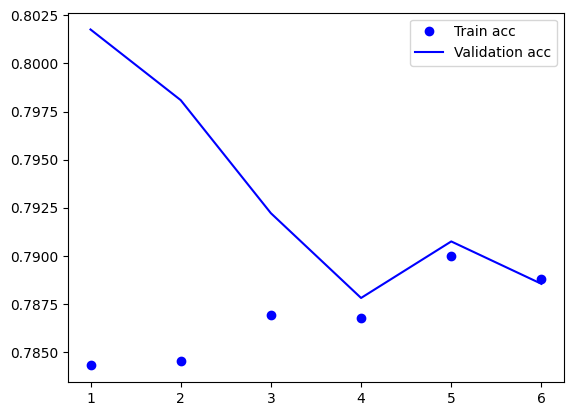

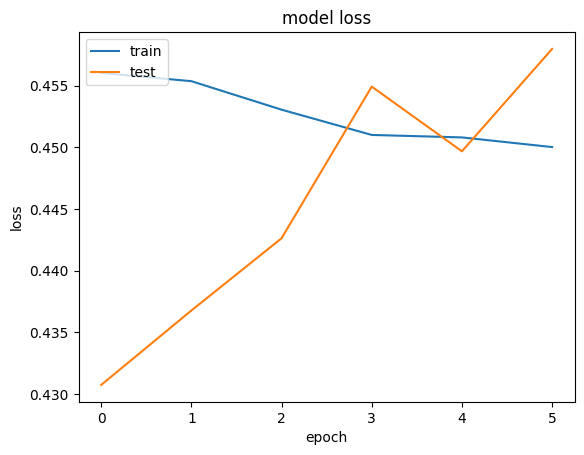

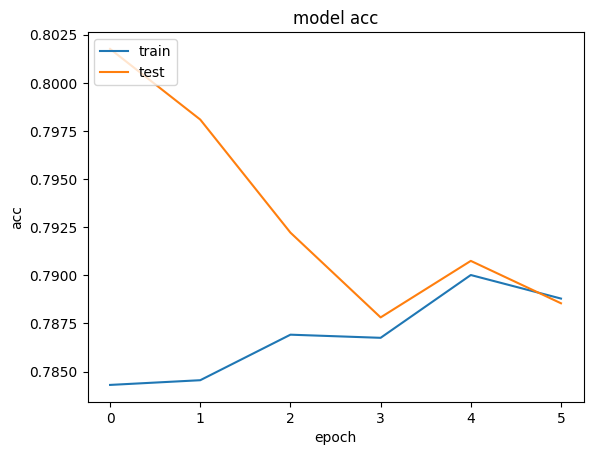

In [205]:
NB_START_EPOCHS = 6
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()
    
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
eval_metric(model_history, 'loss')
eval_metric(model_history, 'acc')
plot_eval_metrics(model_history, 'loss')
plot_eval_metrics(model_history, 'acc')